In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
import os
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2  # For edge detection (crease extraction)

# Tera paths
SESSION1 = r"C:\Users\hiteshk\Desktop\Deep Learning Approaches for roi extraction and using same for palm print recognisation\Tonji\ROI\session1"
SESSION2 = r"C:\Users\hiteshk\Desktop\Deep Learning Approaches for roi extraction and using same for palm print recognisation\Tonji\ROI\session2"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROI_SIZE = 128
print(f"Transformer-based crease-preserving augmentation for {ROI_SIZE}x{ROI_SIZE} ROIs")
print(f"Device: {device}")

Transformer-based crease-preserving augmentation for 128x128 ROIs
Device: cuda


In [3]:
class PalmROIDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.files = []
        self.labels = []
        for path in paths:
            for file in os.listdir(path):
                if file.lower().endswith('.bmp'):
                    try:
                        prefix = file[:4]
                        if prefix.isdigit():  # Check if prefix is numeric
                            person_id = int(prefix) - 1  # Convert to 0-299
                            if 0 <= person_id < 300:  # Valid ID range
                                self.files.append(os.path.join(path, file))
                                self.labels.append(person_id)
                            else:
                                print(f"Skipping file {file}: Person ID {person_id + 1} out of range (1-300 expected)")
                        else:
                            print(f"Skipping file {file}: Non-numeric prefix '{prefix}'")
                    except Exception as e:
                        print(f"Skipping file {file}: Error processing prefix ({str(e)})")
        self.transform = transform
        
        # Print dataset summary for debugging
        print(f"Loaded {len(self.files)} real ROIs (.bmp) for {len(set(self.labels))} unique classes")
        if len(self.files) == 0:
            print("Warning: No valid files loaded. Check dataset paths or file naming.")
        else:
            label_counts = {i: self.labels.count(i) for i in set(self.labels)}
            print("Label distribution:", label_counts)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert('RGB')
        img = img.resize((ROI_SIZE, ROI_SIZE))
        
        # Crease map
        img_np = np.array(img)
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        crease_map = cv2.Canny(gray, 50, 150) / 255.0
        crease_map = torch.tensor(crease_map).unsqueeze(0).float()  # [1, 128, 128]
        
        if self.transform:
            img = self.transform(img)
        
        return img, crease_map, self.labels[idx]

basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = PalmROIDataset([SESSION1, SESSION2], basic_transform)
loader = DataLoader(dataset, batch_size=16, shuffle=True)
print("Dataset ready: Handles .bmp images with robust label extraction, returns ROI, crease map, label")

Skipping file 00001.bmp: Person ID 0 out of range (1-300 expected)
Skipping file 00002.bmp: Person ID 0 out of range (1-300 expected)
Skipping file 00003.bmp: Person ID 0 out of range (1-300 expected)
Skipping file 00004.bmp: Person ID 0 out of range (1-300 expected)
Skipping file 00005.bmp: Person ID 0 out of range (1-300 expected)
Skipping file 00006.bmp: Person ID 0 out of range (1-300 expected)
Skipping file 00007.bmp: Person ID 0 out of range (1-300 expected)
Skipping file 00008.bmp: Person ID 0 out of range (1-300 expected)
Skipping file 00009.bmp: Person ID 0 out of range (1-300 expected)
Skipping file 03010.bmp: Person ID 301 out of range (1-300 expected)
Skipping file 03011.bmp: Person ID 301 out of range (1-300 expected)
Skipping file 03012.bmp: Person ID 301 out of range (1-300 expected)
Skipping file 03013.bmp: Person ID 301 out of range (1-300 expected)
Skipping file 03014.bmp: Person ID 301 out of range (1-300 expected)
Skipping file 03015.bmp: Person ID 301 out of range 

In [4]:
class CrossAttention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.out = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x, condition):
        B, N, D = x.shape
        _, M, _ = condition.shape
        x = self.norm(x)
        condition = self.norm(condition)
        q = self.query(x).view(B, N, self.heads, D // self.heads).transpose(1, 2)
        k = self.key(condition).view(B, M, self.heads, D // self.heads).transpose(1, 2)
        v = self.value(condition).view(B, M, self.heads, D // self.heads).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        out = self.out(out)
        return self.dropout(out) + x

class TransformerAugmenter(nn.Module):
    def __init__(self, dim=256, heads=8, depth=4):
        super().__init__()
        self.dim = dim  # Store dim
        self.patch_size = 8
        self.num_patches = (ROI_SIZE // self.patch_size) ** 2
        self.crease_embed = nn.Conv2d(1, self.dim//8, 4, stride=2, padding=1)
        self.patch_embed = nn.Linear(3 * self.patch_size * self.patch_size, self.dim)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, self.dim) * 0.02)
        self.noise_embed = nn.Linear(64, self.dim)
        self.blocks = nn.ModuleList([
            nn.ModuleList([
                nn.TransformerEncoderLayer(
                    d_model=self.dim, nhead=heads, dim_feedforward=self.dim*2,
                    dropout=0.1, batch_first=True
                ),
                CrossAttention(dim=self.dim, heads=heads)
            ]) for _ in range(depth)
        ])
        self.to_pixels = nn.Linear(self.dim, 3 * self.patch_size * self.patch_size)
        self.cond_linear = nn.Linear(self.dim//8, self.dim).to(device)  # Fixed: Initialize here
    
    def forward(self, crease_map, noise=None):
        B = crease_map.shape[0]
        cond_emb = self.crease_embed(crease_map)
        cond_emb = cond_emb.flatten(2).transpose(1, 2)
        cond_emb = self.cond_linear(cond_emb)  # Fixed: Use self.cond_linear
        if noise is None:
            noise = torch.randn(B, self.num_patches, 64).to(device)
        x = self.noise_embed(noise) + self.pos_embed
        for self_attn, cross_attn in self.blocks:
            x = self_attn(x)
            x = cross_attn(x, cond_emb)
        pixels = torch.sigmoid(self.to_pixels(x))
        roi = pixels.view(B, self.num_patches, 3, self.patch_size, self.patch_size)
        roi = rearrange(roi, 'b (h w) c p q -> b c (h p) (w q)', 
                       h=int(np.sqrt(self.num_patches)), w=int(np.sqrt(self.num_patches)))
        return roi

augmenter = TransformerAugmenter().to(device)
optimizer = torch.optim.Adam(augmenter.parameters(), lr=1e-4)
criterion = nn.MSELoss()
print("Fixed Transformer Augmenter ready!")

Fixed Transformer Augmenter ready!


Epoch 1: 100%|██████████| 750/750 [45:11<00:00,  3.62s/it]


Epoch 1: Avg Loss = 0.0671


Epoch 2: 100%|██████████| 750/750 [1:49:43<00:00,  8.78s/it]      


Epoch 2: Avg Loss = 0.0504


Epoch 3: 100%|██████████| 750/750 [47:22<00:00,  3.79s/it]


Epoch 3: Avg Loss = 0.0522


Epoch 4: 100%|██████████| 750/750 [47:46<00:00,  3.82s/it]


Epoch 4: Avg Loss = 0.0503


Epoch 5: 100%|██████████| 750/750 [3:38:37<00:00, 17.49s/it]      


Epoch 5: Avg Loss = 0.0485


Epoch 6: 100%|██████████| 750/750 [46:35<00:00,  3.73s/it]


Epoch 6: Avg Loss = 0.0483


Epoch 7: 100%|██████████| 750/750 [46:30<00:00,  3.72s/it]


Epoch 7: Avg Loss = 0.0480


Epoch 8: 100%|██████████| 750/750 [47:55<00:00,  3.83s/it]


Epoch 8: Avg Loss = 0.0475


Epoch 9: 100%|██████████| 750/750 [46:38<00:00,  3.73s/it]


Epoch 9: Avg Loss = 0.0484


Epoch 10: 100%|██████████| 750/750 [47:17<00:00,  3.78s/it]


Epoch 10: Avg Loss = 0.0473


Epoch 11: 100%|██████████| 750/750 [6:10:44<00:00, 29.66s/it]     


Epoch 11: Avg Loss = 0.0477


Epoch 12: 100%|██████████| 750/750 [3:57:20<00:00, 18.99s/it]      


Epoch 12: Avg Loss = 0.0471


Epoch 13: 100%|██████████| 750/750 [46:17<00:00,  3.70s/it]


Epoch 13: Avg Loss = 0.0463


Epoch 14: 100%|██████████| 750/750 [46:48<00:00,  3.74s/it]


Epoch 14: Avg Loss = 0.0465


Epoch 15: 100%|██████████| 750/750 [46:45<00:00,  3.74s/it]


Epoch 15: Avg Loss = 0.0472


Epoch 16: 100%|██████████| 750/750 [45:19<00:00,  3.63s/it]


Epoch 16: Avg Loss = 0.0465


Epoch 17: 100%|██████████| 750/750 [1:23:03<00:00,  6.65s/it]    


Epoch 17: Avg Loss = 0.0476


Epoch 18: 100%|██████████| 750/750 [46:19<00:00,  3.71s/it]


Epoch 18: Avg Loss = 0.0463


Epoch 19: 100%|██████████| 750/750 [46:54<00:00,  3.75s/it]


Epoch 19: Avg Loss = 0.0467


Epoch 20: 100%|██████████| 750/750 [1:02:20<00:00,  4.99s/it]  


Epoch 20: Avg Loss = 0.0463


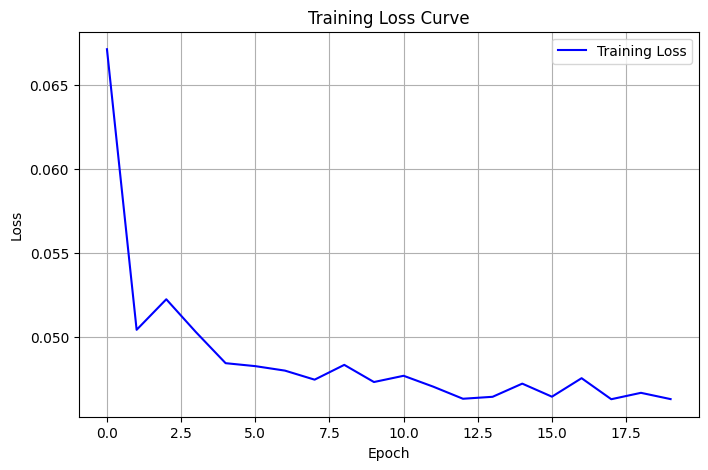

Training complete - creases preserved!


In [4]:
def train_augmenter(epochs=20):
    augmenter.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for real_rois, crease_maps, _ in tqdm(loader, desc=f"Epoch {epoch+1}"):
            real_rois = real_rois.to(device)
            crease_maps = crease_maps.to(device)
            B = real_rois.shape[0]
            noise = torch.randn(B, augmenter.num_patches, 64).to(device)
            synthetic_rois = augmenter(crease_maps, noise)
            
            # Texture loss
            loss = criterion(synthetic_rois, real_rois)
            
            # Crease preservation
            synth_np = synthetic_rois[0].detach().
            cpu().numpy().transpose(1,2,0)
            synth_creases = cv2.Canny((synth_np * 255).astype(np.uint8), 50, 150) / 255.0
            real_creases = crease_maps[0].cpu().numpy().squeeze()
            crease_loss = nn.MSELoss()(torch.tensor(synth_creases).to(device), 
                                     torch.tensor(real_creases).to(device))
            
            total_loss += (loss + 0.5 * crease_loss).item()
            optimizer.zero_grad()
            (loss + 0.5 * crease_loss).backward()
            optimizer.step()
        
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}")
    
    torch.save(augmenter.state_dict(), 'crease_preserving_transformer.pth')
    plt.figure(figsize=(8, 5))
    plt.plot(losses, 'b-', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_loss.png', dpi=300)
    plt.show()
    print("Training complete - creases preserved!")

train_augmenter()

Real Crease Shape: (128, 128)
Real Crease Non-Zero Count: 4622
Synthetic Crease 1 Shape: (128, 128)
Synthetic Crease 1 Non-Zero Count: 1171
Synthetic Crease 2 Shape: (128, 128)
Synthetic Crease 2 Non-Zero Count: 1200
Synthetic Crease 3 Shape: (128, 128)
Synthetic Crease 3 Non-Zero Count: 1228
Synthetic Crease 4 Shape: (128, 128)
Synthetic Crease 4 Non-Zero Count: 1190
Synthetic Crease 5 Shape: (128, 128)
Synthetic Crease 5 Non-Zero Count: 1231


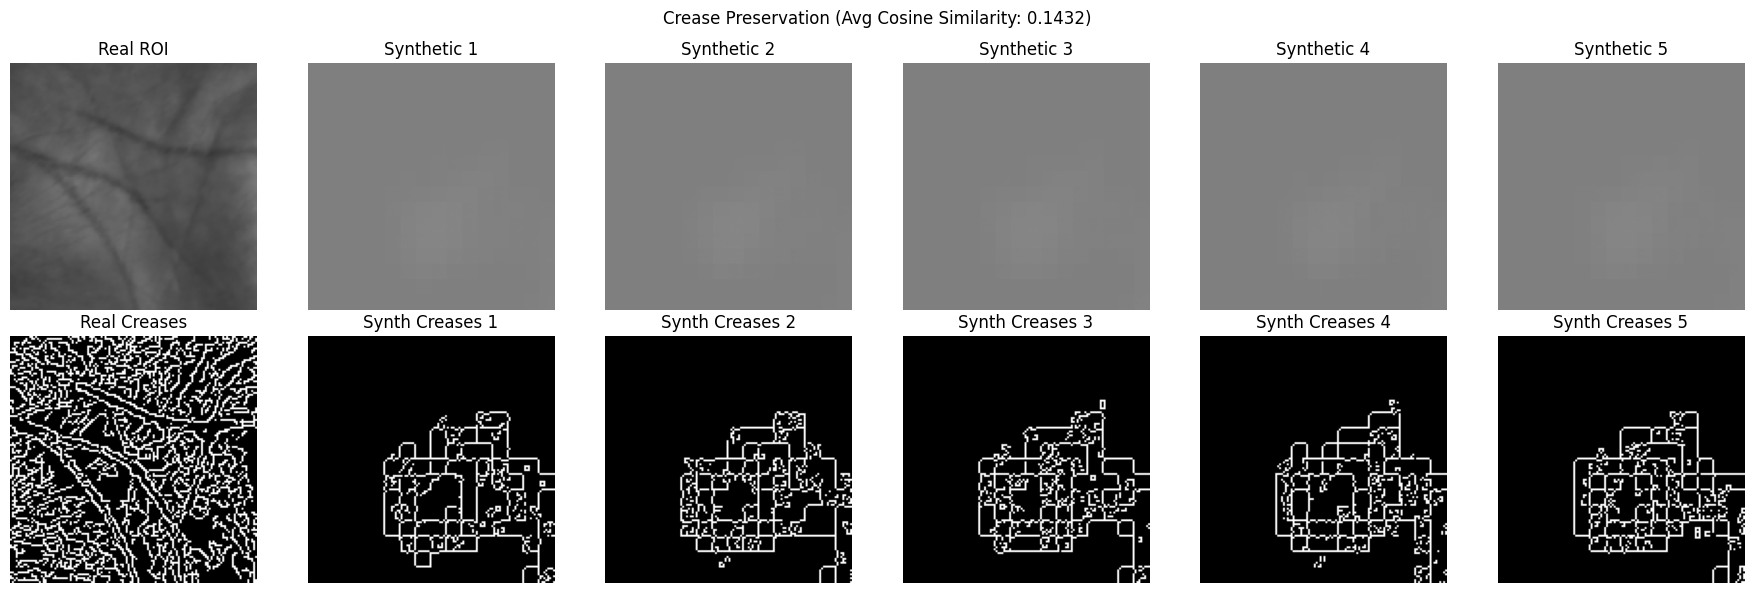

Average crease similarity: 0.1432
Individual similarities: [0.14227695763111115, 0.14861494302749634, 0.14397263526916504, 0.14113657176494598, 0.14002400636672974]


In [5]:
augmenter.load_state_dict(torch.load('crease_preserving_transformer.pth'))
augmenter.eval()

def generate_augmented_rois(real_roi, crease_map, num_variants=5):
    real_roi = real_roi.unsqueeze(0).to(device)
    crease_map = crease_map.unsqueeze(0).to(device)
    variants = []
    with torch.no_grad():
        for _ in range(num_variants):
            noise = torch.randn(1, augmenter.num_patches, 64).to(device)
            synth_roi = augmenter(crease_map, noise)
            variants.append(synth_roi.cpu())
    return torch.cat(variants, dim=0)

def visualize_crease_preservation(real_roi, crease_map, synthetic_rois):
    # Prepare real ROI and crease map
    real_display = (real_roi.permute(1,2,0).numpy() + 1) / 2
    real_np = (real_display * 255).astype(np.uint8)
    if real_np.shape[-1] == 3:
        real_np = cv2.cvtColor(real_np, cv2.COLOR_RGB2GRAY)
    real_np = cv2.equalizeHist(real_np)  # Consistent preprocessing
    real_crease = cv2.Canny(real_np, 30, 100) / 255.0  # Lower thresholds
    
    # Debugging: Save real grayscale and crease map
    cv2.imwrite('real_grayscale.png', real_np)
    cv2.imwrite('real_crease.png', (real_crease * 255).astype(np.uint8))
    print("Real Crease Shape:", real_crease.shape)
    print("Real Crease Non-Zero Count:", np.count_nonzero(real_crease))
    
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))
    axes[0,0].imshow(real_display)
    axes[0,0].set_title('Real ROI')
    axes[0,0].axis('off')
    axes[1,0].imshow(real_crease, cmap='gray')
    axes[1,0].set_title('Real Creases')
    axes[1,0].axis('off')
    
    similarities = []
    for i in range(5):
        synth_display = (synthetic_rois[i].permute(1,2,0).numpy() + 1) / 2
        synth_np = (synth_display * 255).astype(np.uint8)
        if synth_np.shape[-1] == 3:
            synth_np = cv2.cvtColor(synth_np, cv2.COLOR_RGB2GRAY)
        synth_np = cv2.equalizeHist(synth_np)  # Consistent preprocessing
        synth_crease = cv2.Canny(synth_np, 30, 100) / 255.0
        
        # Debugging: Save synthetic grayscale and crease map
        cv2.imwrite(f'synth_grayscale_{i+1}.png', synth_np)
        cv2.imwrite(f'synth_crease_{i+1}.png', (synth_crease * 255).astype(np.uint8))
        print(f"Synthetic Crease {i+1} Shape:", synth_crease.shape)
        print(f"Synthetic Crease {i+1} Non-Zero Count:", np.count_nonzero(synth_crease))
        
        axes[0,i+1].imshow(synth_display)
        axes[0,i+1].set_title(f'Synthetic {i+1}')
        axes[0,i+1].axis('off')
        axes[1,i+1].imshow(synth_crease, cmap='gray')
        axes[1,i+1].set_title(f'Synth Creases {i+1}')
        axes[1,i+1].axis('off')
        
        if np.count_nonzero(real_crease) > 0 and np.count_nonzero(synth_crease) > 0:
            sim = nn.CosineSimilarity(dim=0)(
                torch.tensor(real_crease, dtype=torch.float32).flatten(),
                torch.tensor(synth_crease, dtype=torch.float32).flatten()
            )
            similarities.append(sim.item())
        else:
            print(f"Warning: Zero-valued crease map for Synthetic {i+1}, skipping similarity")
            similarities.append(0.0)
    
    avg_similarity = np.mean(similarities) if similarities else 0.0
    plt.suptitle(f'Crease Preservation (Avg Cosine Similarity: {avg_similarity:.4f})')
    plt.tight_layout()
    plt.savefig('crease_preservation.png', dpi=300)
    plt.show()
    print(f"Average crease similarity: {avg_similarity:.4f}")
    print(f"Individual similarities: {similarities}")

real_roi, crease_map, _ = dataset[0]
synthetic_rois = generate_augmented_rois(real_roi, crease_map)
visualize_crease_preservation(real_roi, crease_map, synthetic_rois)

In [6]:
def create_analysis_dataset(augmenter, dataset, num_real_per_class=10, num_synth_per_class=10):
    real_by_class = {i: [] for i in range(300)}
    synth_by_class = {i: [] for i in range(300)}
    
    print("Creating analysis dataset...")
    augmenter.eval()
    
    for real_roi, crease_map, label in tqdm(dataset):
        if len(real_by_class[label]) < num_real_per_class:
            real_by_class[label].append(real_roi)
            synth_variants = generate_augmented_rois(real_roi, crease_map, num_synth_per_class)
            # Store individual synthetic ROIs instead of concatenating
            for i in range(num_synth_per_class):
                synth_by_class[label].append(synth_variants[i])
    
    for class_id in range(300):
        real_by_class[class_id] = real_by_class[class_id][:num_real_per_class]
        synth_by_class[class_id] = synth_by_class[class_id][:num_synth_per_class]
        # Ensure empty classes have empty lists
        if not synth_by_class[class_id]:
            synth_by_class[class_id] = []
    
    print(f"Real: {sum(len(v) for v in real_by_class.values())} ROIs")
    print(f"Synthetic: {sum(len(v) for v in synth_by_class.values())} ROIs")
    return real_by_class, synth_by_class

test_size = int(0.2 * len(dataset))
test_dataset = torch.utils.data.Subset(dataset, range(test_size))
real_by_class, synth_by_class = create_analysis_dataset(augmenter, test_dataset)

Creating analysis dataset...


100%|██████████| 1200/1200 [02:57<00:00,  6.77it/s]

Real: 1200 ROIs
Synthetic: 1200 ROIs


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
def compute_intra_class_variation(rois_by_class, method='cosine'):
    variations = []
    class_ids = []
    
    for class_id, rois in tqdm(rois_by_class.items(), desc="Computing variation"):
        if len(rois) < 2:
            continue
        features = torch.stack(rois).view(len(rois), -1).cpu().numpy()
        distances = 1 - cosine_similarity(features)
        avg_variation = np.mean(distances[np.triu_indices_from(distances, k=1)])
        variations.append(avg_variation)
        class_ids.append(class_id)
    
    return np.array(class_ids), np.array(variations)

real_class_ids, real_variations = compute_intra_class_variation(real_by_class)
synth_class_ids, synth_variations = compute_intra_class_variation(synth_by_class)

Computing variation: 100%|██████████| 300/300 [00:00<00:00, 759.51it/s]


C:\Users\hiteshk\AppData\Local\Temp\ipykernel_9676\3126822100.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,1].boxplot([real_variations, synth_variations], labels=['Real', 'Synthetic'])


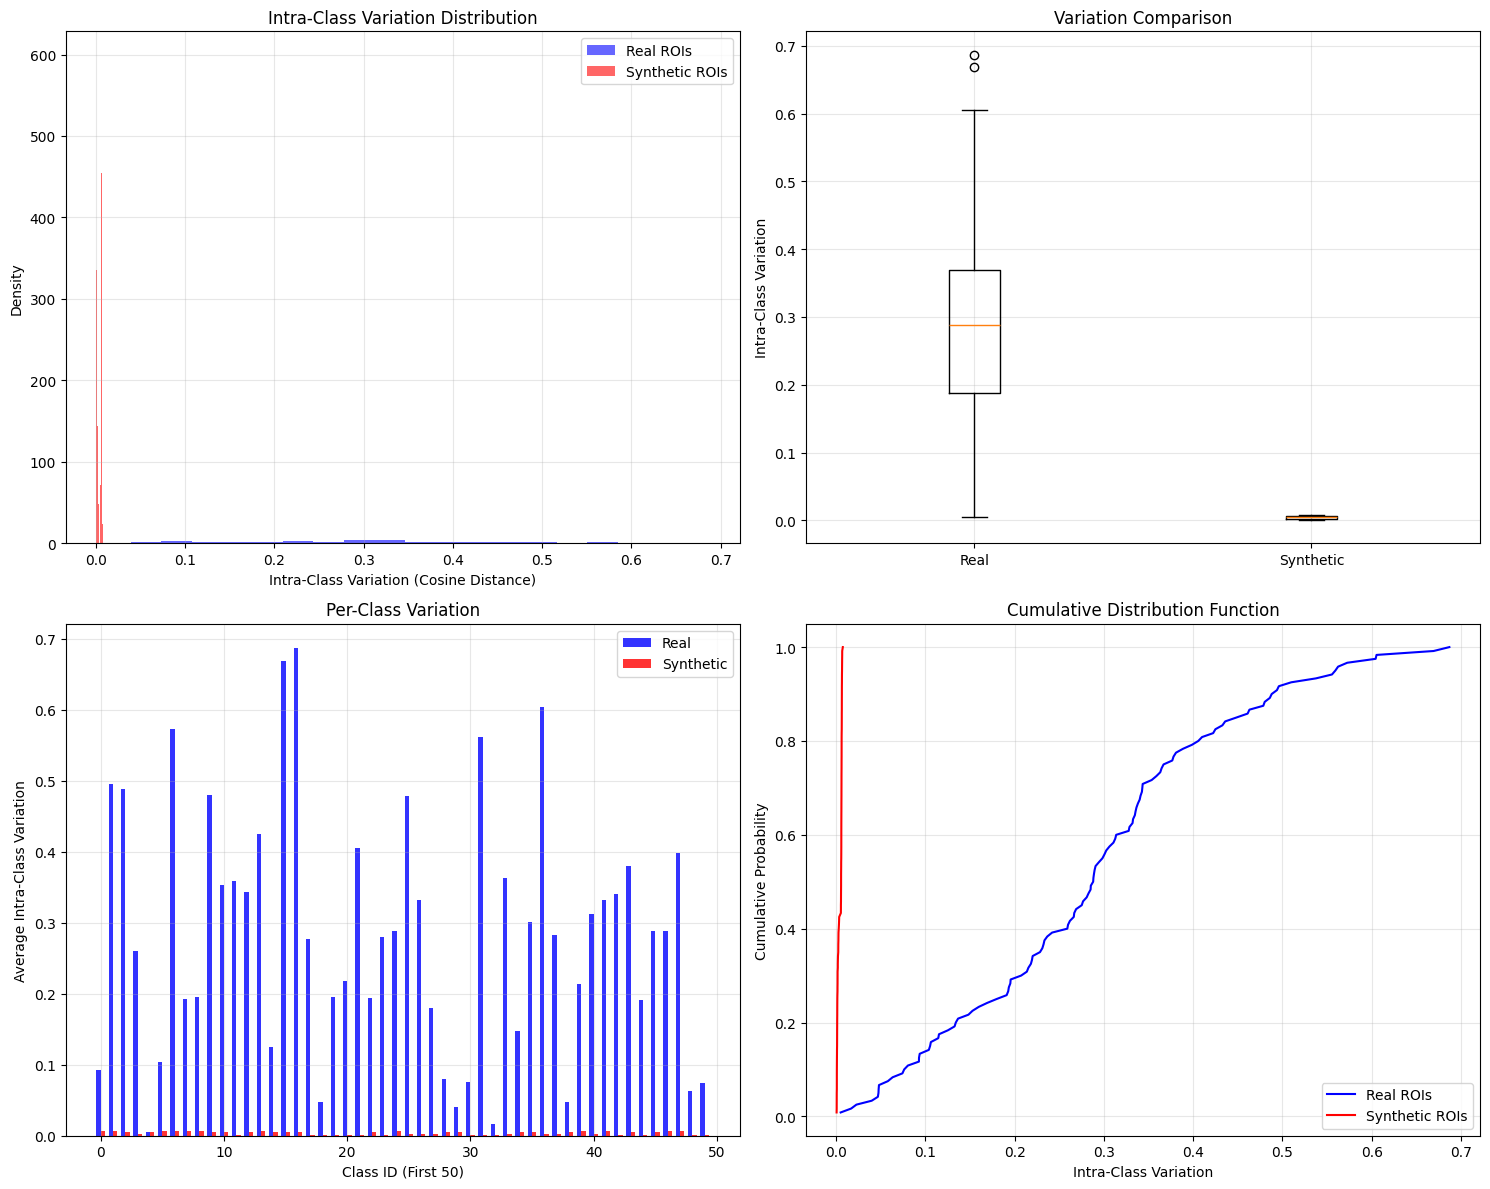

Real Mean Variation: 0.2867 ± 0.1517
Synthetic Mean Variation: 0.0042 ± 0.0023


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0,0].hist(real_variations, bins=20, alpha=0.6, label='Real ROIs', color='blue', density=True)
axes[0,0].hist(synth_variations, bins=20, alpha=0.6, label='Synthetic ROIs', color='red', density=True)
axes[0,0].set_xlabel('Intra-Class Variation (Cosine Distance)')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Intra-Class Variation Distribution')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].boxplot([real_variations, synth_variations], labels=['Real', 'Synthetic'])
axes[0,1].set_ylabel('Intra-Class Variation')
axes[0,1].set_title('Variation Comparison')
axes[0,1].grid(True, alpha=0.3)

sample_classes = sorted(list(set(real_class_ids))[:50])
real_sample = [np.mean(real_variations[real_class_ids == c]) for c in sample_classes]
synth_sample = [np.mean(synth_variations[synth_class_ids == c]) for c in sample_classes]
x = np.arange(len(sample_classes))
width = 0.35
axes[1,0].bar(x - width/2, real_sample, width, label='Real', color='blue', alpha=0.8)
axes[1,0].bar(x + width/2, synth_sample, width, label='Synthetic', color='red', alpha=0.8)
axes[1,0].set_xlabel('Class ID (First 50)')
axes[1,0].set_ylabel('Average Intra-Class Variation')
axes[1,0].set_title('Per-Class Variation')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

sorted_real = np.sort(real_variations)
sorted_synth = np.sort(synth_variations)
cdf_real = np.arange(1, len(sorted_real) + 1) / len(sorted_real)
cdf_synth = np.arange(1, len(sorted_synth) + 1) / len(sorted_synth)
axes[1,1].plot(sorted_real, cdf_real, 'b-', label='Real ROIs')
axes[1,1].plot(sorted_synth, cdf_synth, 'r-', label='Synthetic ROIs')
axes[1,1].set_xlabel('Intra-Class Variation')
axes[1,1].set_ylabel('Cumulative Probability')
axes[1,1].set_title('Cumulative Distribution Function')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('intra_class_variation_300_classes.png', dpi=300)
plt.show()

print(f"Real Mean Variation: {np.mean(real_variations):.4f} ± {np.std(real_variations):.4f}")
print(f"Synthetic Mean Variation: {np.mean(synth_variations):.4f} ± {np.std(synth_variations):.4f}")